## Data Loading and Preprocessing

In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import torch
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion() 

import os
print(os.listdir("../input"))

['faces']


# Dataset
* Dataset: Facial pose dataset
* Contains images and corresponding Landmarks
* 68 different landmark points are annotated for each face
<img src="https://i.imgur.com/VSLwYQC.png"/>

In [2]:
landmarks_frame = pd.read_csv('../input/faces/faces/face_landmarks.csv')

n = 64
image_names = landmarks_frame.iloc[n,0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype(float).reshape(-1,2)

print("Image name: {}".format(image_names))
print("Landmarks shape: {}".format(landmarks.shape))
print("4 Landmarks {}".format(landmarks[:4]))

Image name: matt-mathes.jpg
Landmarks shape: (68, 2)
4 Landmarks [[ 85. 152.]
 [ 83. 173.]
 [ 83. 195.]
 [ 85. 217.]]


`show_landmarks` plots landmarks

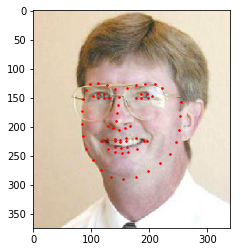

In [3]:
#plot landmarks

def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
#     plt.plot(landmarks[:, 0], landmarks[:, 1], 'r-', linewidth=2, markersize=10)
    plt.pause(0.001)
    
plt.figure()
show_landmarks(io.imread(os.path.join('../input/faces/faces', image_names)), landmarks)
plt.show()

# Dataset
* Dataset class
    * `torch.utils.data.Dataset` is abstract class representing a dataset.
    * Custom dataset should inherit Dataset class and override following methods
        * `__len__(self)` : len(dataset) returns the size of the dataset.
        * `__getitem__(self, index)` : supports indexing such that dataset[i] can be used to retrieve ith sample.

In [4]:
class FaceLandmarksDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform = False):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        image = io.imread(os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0]))
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype(float).reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

Create a dataset and print 4 samples

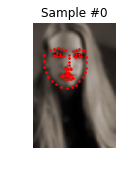

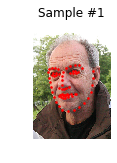

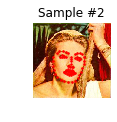

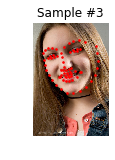

In [5]:
face_dataset = FaceLandmarksDataset(csv_file = '../input/faces/faces/face_landmarks.csv', root_dir = '../input/faces/faces')
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    sbplot = plt.subplot(1,4,i+1)
    plt.tight_layout()
    sbplot.axis('off')
    sbplot.set_title("Sample #{}".format(i))
    show_landmarks(**sample)
    
    if i == 3:
        plt.show()
        break

# Transforms
* `torchvision.transforms` provides callable classes like Resize, RandomCrop, ToTensor, Compose for data augmentation and preprocessing.
* To create custom callable classes, we should implement `__call__` and `__init__` if necessary.
* Below code implements Rescale, RandomCrop and ToTensor custom callable classes.

In [6]:
class Rescale(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        
        landmarks = landmarks * [new_w / w, new_h / h]
        
        return {'image': img, 'landmarks': landmarks}

class RandomCrop(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            self.output_size = output_size
            
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h, left: left + new_w]
        
        landmarks = landmarks - [left, top]
        
        return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        #numpy image: HxWxC
        #torch image: CxHxW
        image = image.transpose((2,0,1))
        
        return {'image': torch.from_numpy(image), 'landmarks': torch.from_numpy(landmarks)}

## Compose transforms
* `torchvision.transforms.Compose` is a simple callable class which allows us to apply transforms as shown below

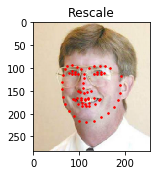

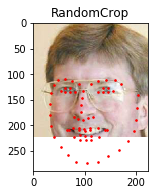

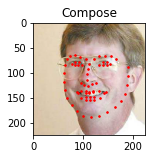

In [7]:
transform_composer = transforms.Compose([Rescale(256), RandomCrop(224)])
scale = Rescale(256)
crop = RandomCrop(224)

fig = plt.figure()
sample = face_dataset[64]
for i, trsfm in enumerate([scale, crop, transform_composer]):
    transformed_sample = trsfm(sample)
    
    sbplt = plt.subplot(1,3,i+1)
    plt.tight_layout()
    sbplt.set_title(type(trsfm).__name__)
    show_landmarks(**transformed_sample)
    
plt.show()

Create a dataset with composed transforms and iterate over data(upto 5 samples)

In [8]:
transformed_dataset = FaceLandmarksDataset(csv_file = '../input/faces/faces/face_landmarks.csv', root_dir = '../input/faces/faces',
                                          transform = transforms.Compose([Rescale(256), RandomCrop(224), ToTensor()]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['landmarks'].size())
    
    if i == 5:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])
4 torch.Size([3, 224, 224]) torch.Size([68, 2])
5 torch.Size([3, 224, 224]) torch.Size([68, 2])


We loose a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:
* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.

`torch.utils.data.DataLoader` is an iterator which provides all these features

In [9]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

print('Data loading complete')
print(dataloader)

Data loading complete
